# Bozza Random forest

Random forest fatta così non ha un cazzo di senso.
Avrà senso aggiungere la Z insieme ai dati e fare un unico grande dataset.
Dopodiche si può fare PCA, per scartare le componenti a due a due mega correlate, visto che rappresenteranno più o meno la stessa grandezza fisica.
Così possiamo ridurre il numero di features e rimane computaizonemlmente meno intensivo.

Altra cosa Mrem secondo me è una buona feature che racchiude varie cose, Dipende da Z, natal kick, m1, m2.

In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.scale import FuncScale

In [5]:
heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,14,15,16,17,25,27]


In [6]:
def extractor(cluster, path_data=path_data):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data) #check what your pc does here
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
        data = data[data['t_elapsed'] != 136000]
    return data

### ML 

In [15]:
def rndmfrst(cluster, listwhattodrop, target, title, n_estimators=50, max_depth=20, random_state=42, n_jobs=6, cv=5):
    dataysc = extractor(cluster)
    #dataysc['DiffSpin'] = abs(dataysc.S2 - dataysc.S1)
    df = dataysc.drop(columns=listwhattodrop)
    del dataysc

    feature_names = list(df.columns)
    feature_names.remove(target)

    X = df.drop(columns=target)
    y = df[target]

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
        'rmse': make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))  # RMSE
    }

    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, return_estimator=True)

    # Compute mean and std for each metric
    print(f"Cross-Validation ({cv}-fold) Results:")
    print(f"R² Score: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
    print(f"MAE: {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")
    print(f"MSE: {cv_results['test_mse'].mean():.4f} ± {cv_results['test_mse'].std():.4f}")
    print(f"RMSE: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")

    best_estimator = cv_results['estimator'][np.argmax(cv_results['test_r2'])]  # Choose model with highest R²
    feature_importances = best_estimator.named_steps['regressor'].feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.grid(True, axis='y', linestyle="--", linewidth=0.6)
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.yscale('log')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return print(f'Feature importances: {feature_importances[sorted_idx]}')


##################### Graphs ################
def hist2dgraph_vecchio( x,y, nxbin,nybin, title, axx, axy, vmin, vmax):
    xbin= np.linspace(x.min(),x.max(),nxbin)
    ybin= np.linspace(y.min(),y.max(),nybin)
    hist = plt.hist2d(x,y,bins=(xbin,ybin), cmap="Blues", norm=colors.LogNorm( vmin=vmin, vmax=vmax))
    plt.xscale('linear')
    plt.yscale('linear')
    plt.title(title)
    plt.xlabel(axx)
    plt.ylabel(axy)
    return hist

def hist2dgraph( x,y, nxbin,nybin, title, axx, axy, vmin, vmax, scale_x='linear', scale_y = 'linear'):
    if scale_x == 'linear':
        xbin= np.linspace(x.min(),x.max(),nxbin)
        plt.xscale('linear')
    elif scale_x == 'log':
        xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)
        plt.xscale('log')
    if scale_y == 'linear':
        ybin= np.linspace(y.min(),y.max(),nybin)
        plt.yscale('linear')
    elif scale_y == 'log':
        ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
        plt.yscale('log')
    hist = plt.hist2d(x,y,bins=(xbin,ybin), cmap="Blues", norm=colors.LogNorm( vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(axx)
    plt.ylabel(axy)
    return hist

Cross-Validation (5-fold) Results:
R² Score: 0.9981 ± 0.0014
MAE: 0.6100 ± 0.1117
MSE: 2.8620 ± 2.3853
RMSE: 1.5624 ± 0.6489


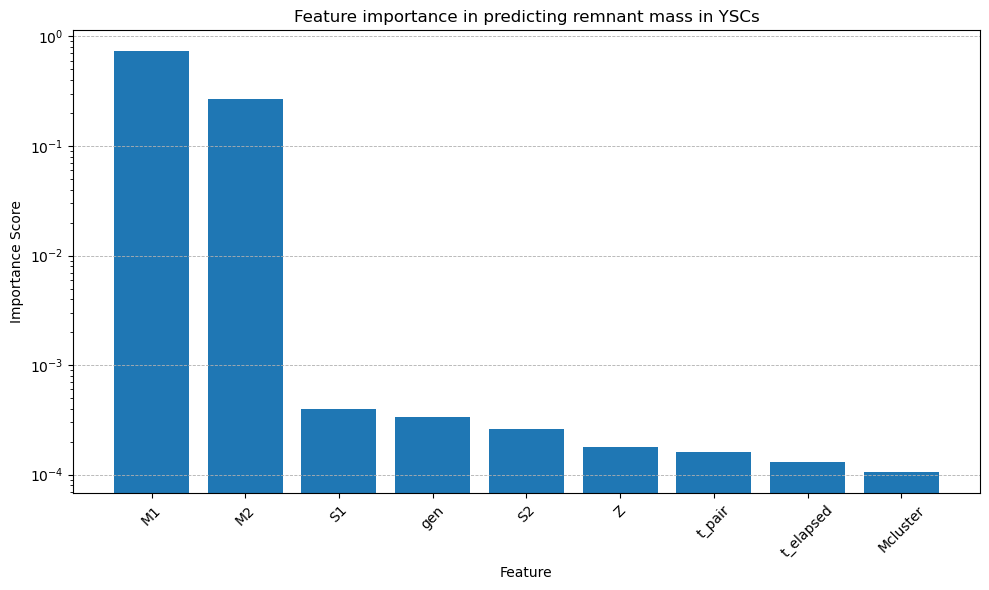

Feature importances: [7.31024772e-01 2.67409940e-01 3.98433191e-04 2.59434984e-04
 1.59929624e-04 1.30738537e-04 1.04916170e-04 3.34144259e-04
 1.77691327e-04]


In [14]:
rndmfrst('ysc',['Srem', 'esca_v','kick'], 'Mrem', "Feature importance in predicting remnant mass in YSCs")

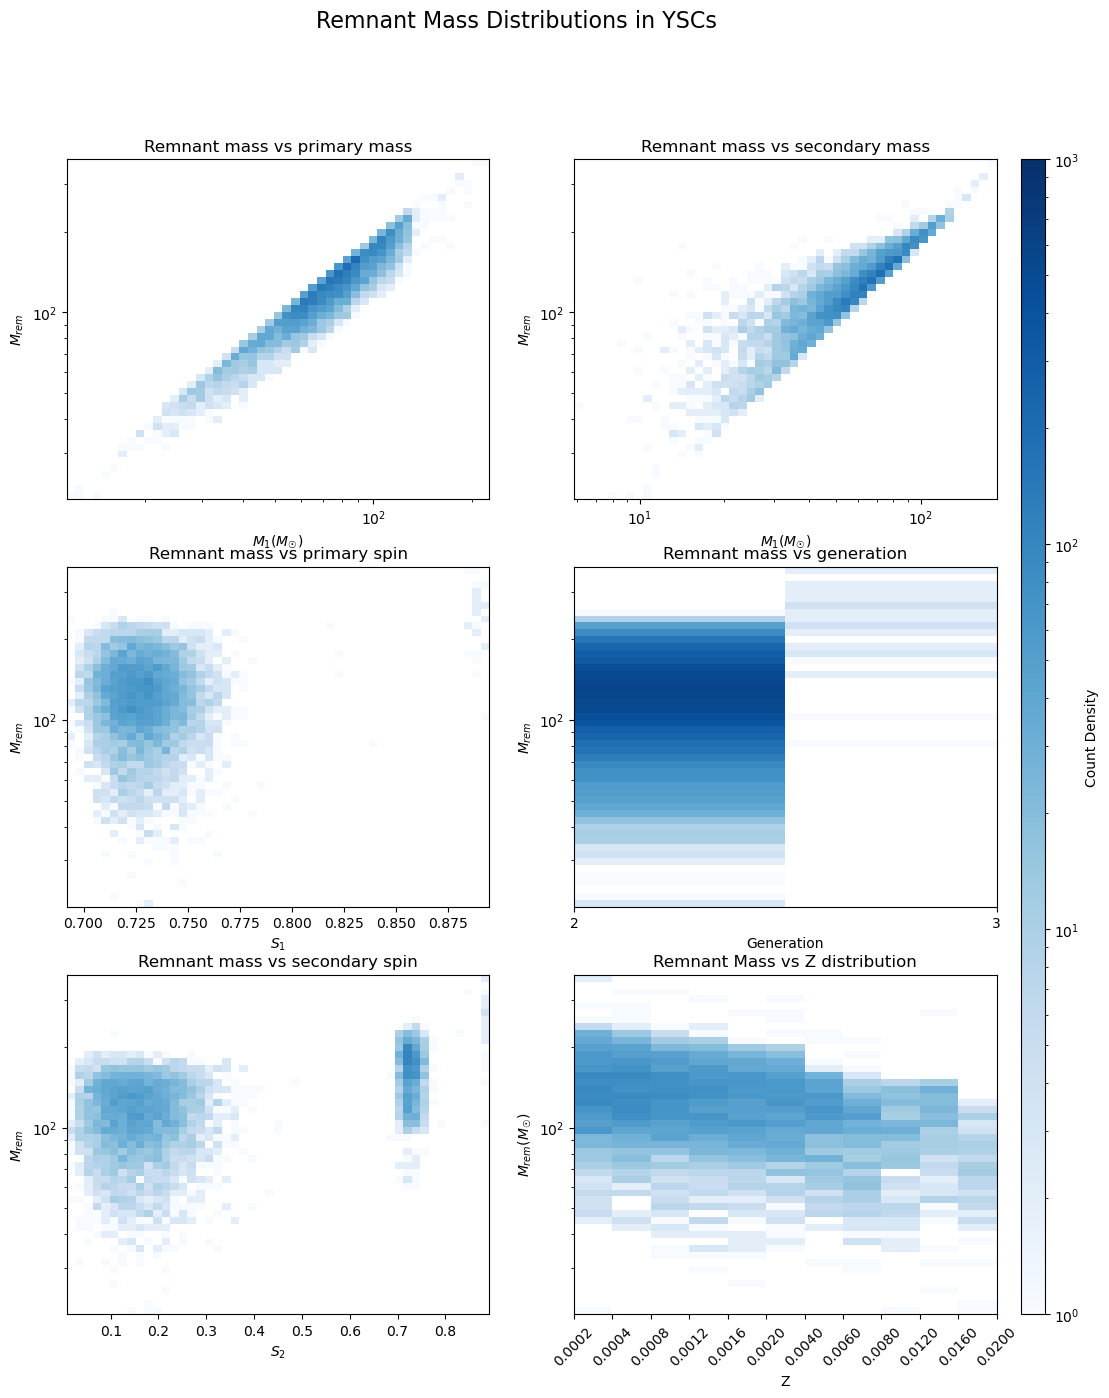

In [19]:
data = extractor('ysc')

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in YSCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.M1,data.Mrem,50,50,'Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, 'log','log')
plt.sca(ax[0,1])

hist2 = hist2dgraph(data.M2,data.Mrem,50,50,'Remnant mass vs secondary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, 'log','log')
plt.sca(ax[1,0])
hist = hist2dgraph(data.S1,data.Mrem,50,50,'Remnant mass vs primary spin',u'$S_1$', u'$M_{rem}$', 1, 1e3, 'linear','log')
plt.sca(ax[1,1])
hist2 = hist2dgraph(data.gen,data.Mrem,3,50,'Remnant mass vs generation',u'Generation', u'$M_{rem}$', 1, 1e3, 'linear','log')
plt.xticks([2,3])
plt.sca(ax[2,0])
jist3 = hist2dgraph(data.S2,data.Mrem,50,50,'Remnant mass vs secondary spin',u'$S_2$', u'$M_{rem}$', 1, 1e3, 'linear','log')
plt.sca(ax[2,1])

z_bins = np.array([2e-4, 4e-4, 8e-4, 12e-4, 16e-4, 2e-3, 4e-3, 6e-3, 8e-3, 12e-3, 16e-3, 2e-2])
Rem_bins = np.logspace(np.log10(data.Mrem.min()),np.log10(data.Mrem.max()),50) 
def forward(x):
    return np.interp(x, z_bins, np.arange(len(z_bins)))

def inverse(x):
    return np.interp(x, np.arange(len(z_bins)), z_bins)

# Create the FuncScale object correctly
scale = FuncScale(ax[2, 1].xaxis, (forward, inverse))
plt.hist2d(data.Z,data.Mrem, bins=(z_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))


# Apply the scale to the x-axis
ax[2, 1].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("log")
plt.title('Remnant Mass vs Z distribution')
plt.xlabel(u'Z')
plt.ylabel(u'$M_{rem} (M_\u2609$)')

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

Cross-Validation (5-fold) Results:
R² Score: 0.9998 ± 0.0002
MAE: 0.1334 ± 0.0147
MSE: 0.4868 ± 0.3984
RMSE: 0.6189 ± 0.3221


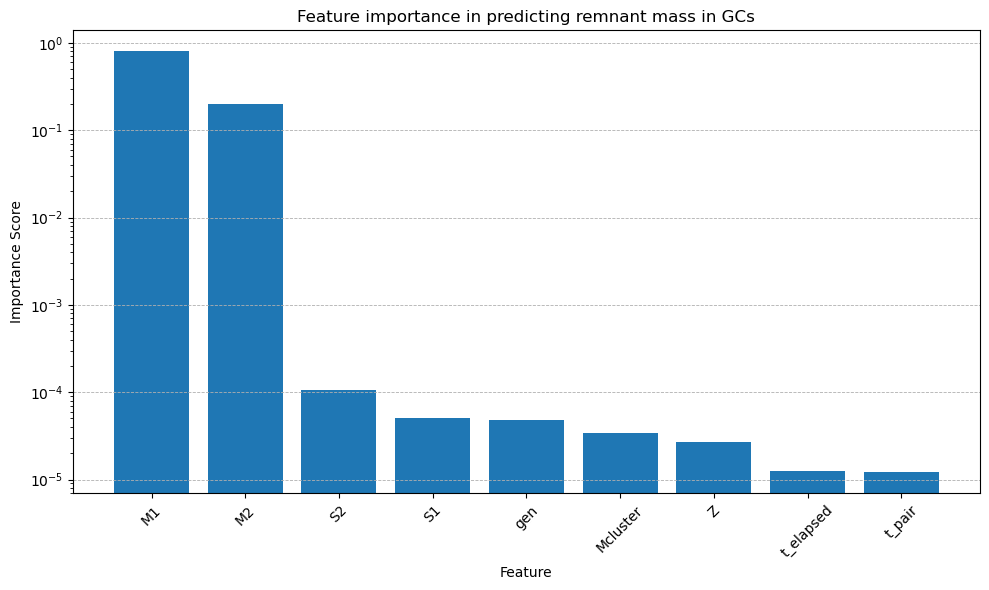

Feature importances: [7.98500440e-01 2.01211000e-01 5.03234249e-05 1.05401643e-04
 1.20644584e-05 1.24794037e-05 3.42226563e-05 4.75051678e-05
 2.65635689e-05]


In [5]:
rndmfrst('gc',['Srem', 'esca_v','kick'], 'Mrem', 'Feature importance in predicting remnant mass in GCs', n_estimators=60, max_depth=15, random_state=42, n_jobs=-1, cv=5  )

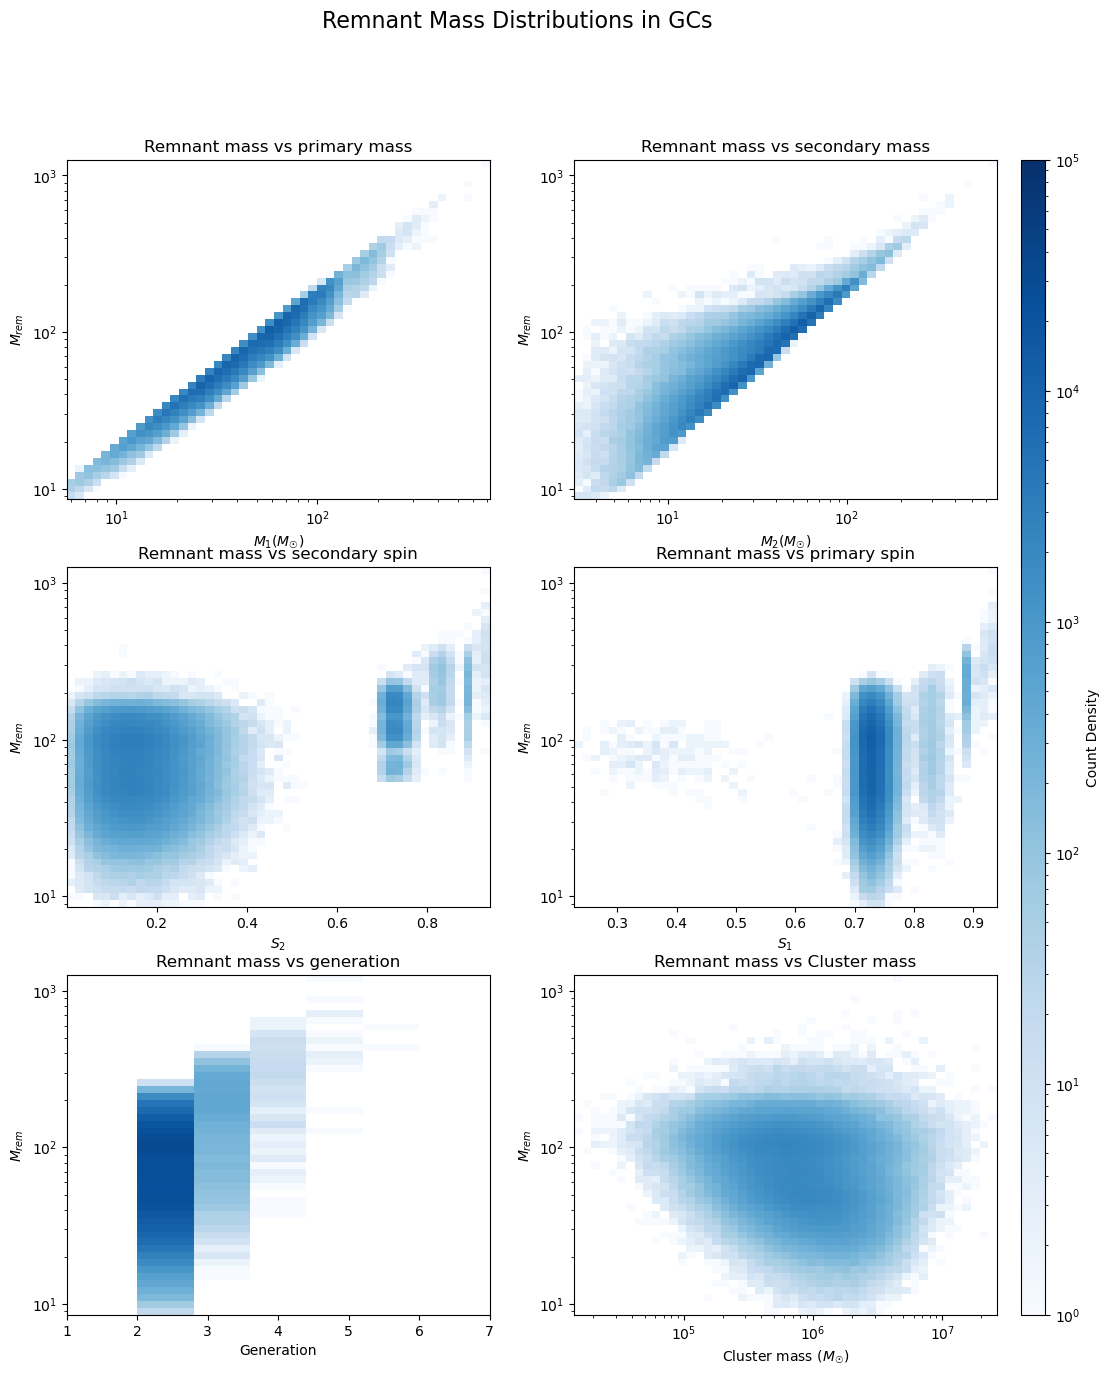

In [16]:
data = extractor('gc')

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in GCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.M1,data.Mrem,50,50,'Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e5, 'log', 'log')
plt.sca(ax[0,1])

hist2 = hist2dgraph(data.M2,data.Mrem,50,50,'Remnant mass vs secondary mass',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 1e5, 'log', 'log')
plt.sca(ax[1,0])
hist = hist2dgraph(data.S2,data.Mrem,50,50,'Remnant mass vs secondary spin',u'$S_2$', u'$M_{rem}$', 1, 1e5, 'linear','log')
plt.sca(ax[1,1])
jist3 = hist2dgraph(data.S1,data.Mrem,50,50,'Remnant mass vs primary spin',u'$S_1$', u'$M_{rem}$', 1, 1e5, 'linear','log')
plt.sca(ax[2,0])
hist2 = hist2dgraph(data.gen,data.Mrem,data.gen.max(),50,'Remnant mass vs generation',u'Generation', u'$M_{rem}$', 1, 1e5, 'linear','log')
plt.xticks([1,2,3,4,5,6,7])

plt.sca(ax[2,1])
hist2 = hist2dgraph(data.Mcluster,data.Mrem,50,50,'Remnant mass vs Cluster mass',u'Cluster mass ($M_{\u2609}$)', u'$M_{rem}$', 1, 1e5,'log', 'log')


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

Cross-Validation (3-fold) Results:
R² Score: 0.9968 ± 0.0031
MAE: 0.8883 ± 0.2547
MSE: 11.2067 ± 11.2975
RMSE: 2.9280 ± 1.6227


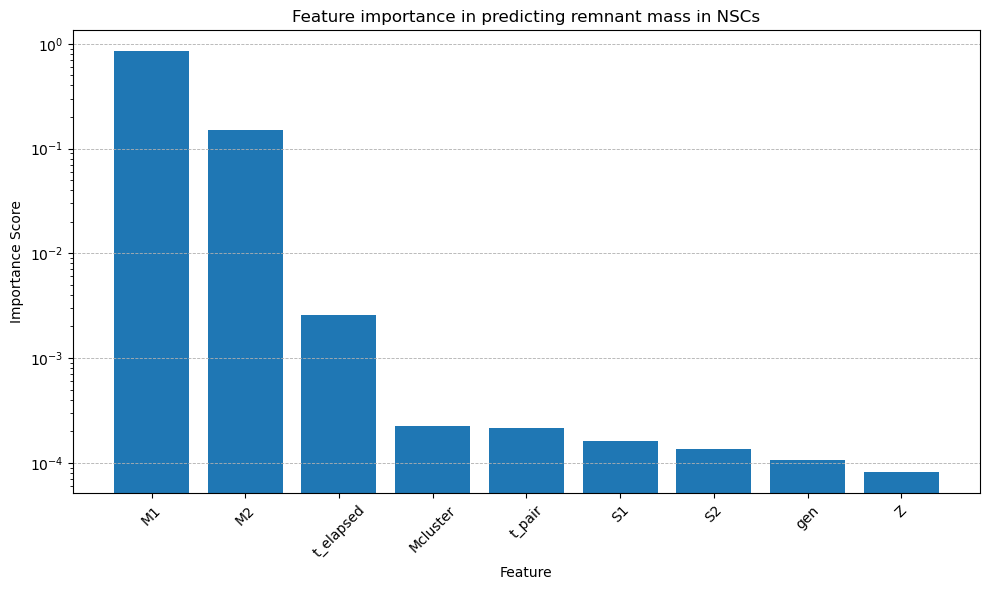

Feature importances: [8.46402416e-01 1.50116230e-01 1.62530660e-04 1.36151251e-04
 2.14038522e-04 2.55872389e-03 2.23228896e-04 1.05832408e-04
 8.08481505e-05]


In [13]:
rndmfrst('nsc',['Srem', 'esca_v','kick'], 'Mrem','Feature importance in predicting remnant mass in NSCs', n_estimators=50, max_depth=10, cv=3 )


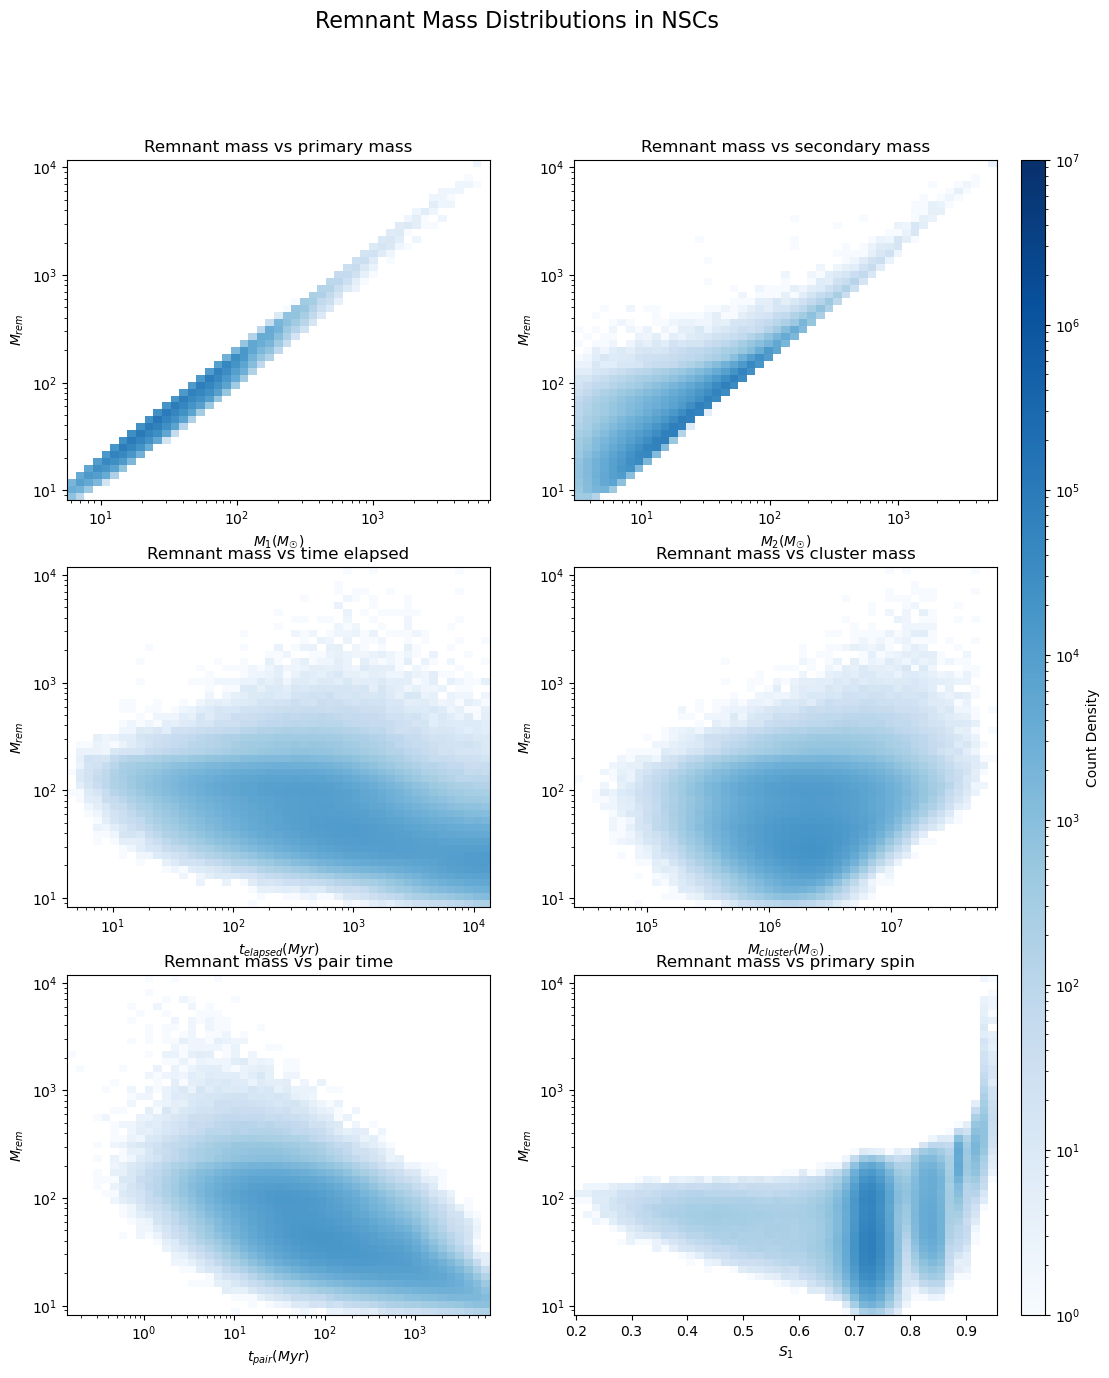

In [20]:
data = extractor('nsc')

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in NSCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.M1,data.Mrem,50,50,'Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log','log')
plt.sca(ax[0,1])

hist2 = hist2dgraph(data.M2,data.Mrem,50,50,'Remnant mass vs secondary mass',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log','log')
plt.sca(ax[1,0])
hist = hist2dgraph(data.t_elapsed,data.Mrem,50,50,'Remnant mass vs time elapsed',u'$t_{elapsed} (Myr)$', u'$M_{rem}$', 1, 1e7,'log', 'log')
plt.sca(ax[1,1])
jist3 = hist2dgraph(data.Mcluster,data.Mrem,50,50,'Remnant mass vs cluster mass',u'$M_{cluster}(M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log','log')
plt.sca(ax[2,0])
hist2 = hist2dgraph(data.t_pair,data.Mrem,50,50,'Remnant mass vs pair time',u'$t_{pair}(Myr)$', u'$M_{rem}$', 1, 1e7, 'log','log')
#plt.xticks([1,2,3,4,5,6,7])

plt.sca(ax[2,1])
hist2 = hist2dgraph(data.S1,data.Mrem,50,50,'Remnant mass vs primary spin',u'$S_1$', u'$M_{rem}$', 1, 1e7, 'linear','log')


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()


Cross-Validation (5-fold) Results:
R² Score: 0.9994 ± 0.0008
MAE: 0.0001 ± 0.0001
MSE: 0.0000 ± 0.0000
RMSE: 0.0013 ± 0.0014


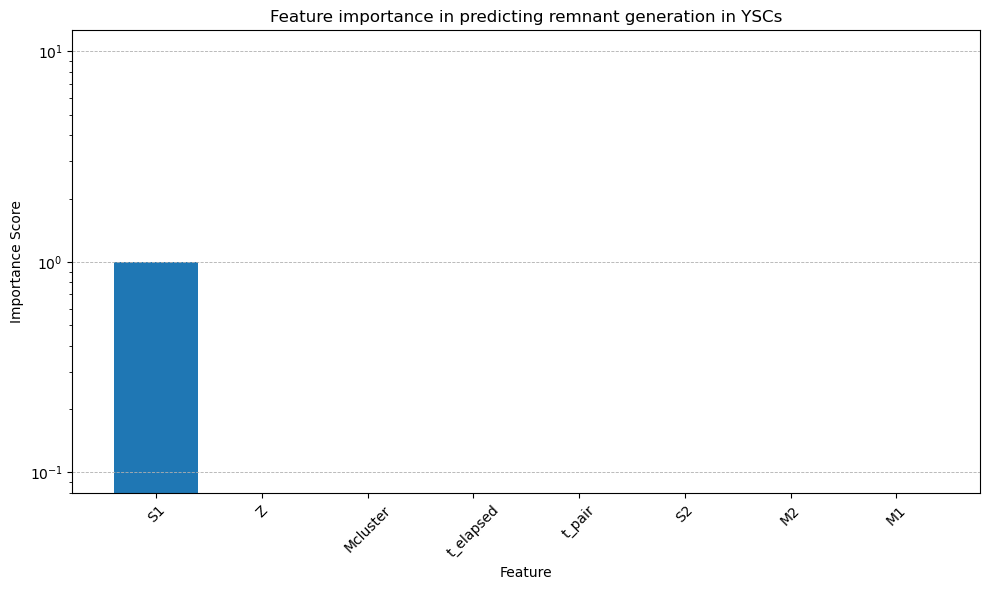

Feature importances: [0. 0. 1. 0. 0. 0. 0. 0.]


In [6]:
rndmfrst('ysc', ['Srem','Mrem', 'kick', 'esca_v'], 'gen', 'Feature importance in predicting remnant generation in YSCs')

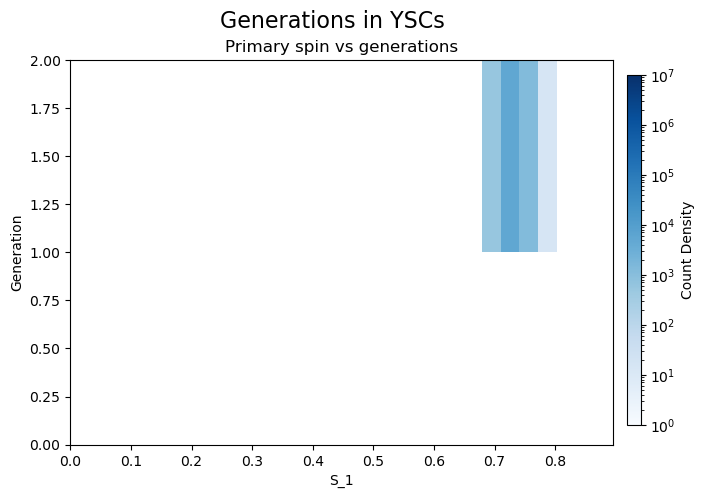

In [16]:
data = extractor('ysc')

fig, ax = plt.subplots(1,1,figsize=(7,5))
fig.suptitle("Generations in YSCs", fontsize=16)
#Select first panel
## Create custom log bins for period and masses
gens = np.arange(data.gen.max())
s_bins = np.linspace(0,data.S1.max(),len(gens)*10)

hist = plt.hist2d(data.S1,data.gen,bins=(s_bins,gens), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e7))
# Use LogNorm to have a log scale in colors, vmin and vmax corresponds to the minium and amaximum value to consider on the scale, 
# you can play with this number untile you are satisfied with the apparence of the plot
plt.xscale("linear")
plt.yscale("linear")
plt.title('Primary spin vs generations')
plt.xlabel(u'S_1')
plt.ylabel(u'Generation')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

Cross-Validation (5-fold) Results:
R² Score: 0.9801 ± 0.0081
MAE: 0.0005 ± 0.0003
MSE: 0.0003 ± 0.0001
RMSE: 0.0164 ± 0.0039


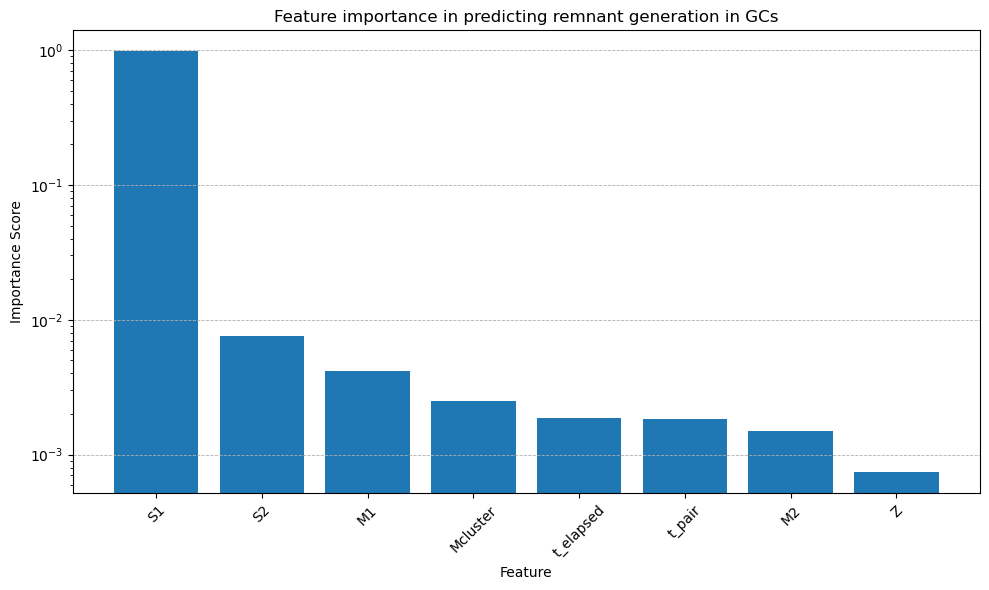

Feature importances: [4.19670626e-03 1.49794580e-03 9.79737172e-01 7.63374921e-03
 1.83803478e-03 1.86917673e-03 2.48911108e-03 7.38103955e-04]


In [5]:
rndmfrst('gc', ['Srem','Mrem', 'kick', 'esca_v'], 'gen', 'Feature importance in predicting remnant generation in GCs')

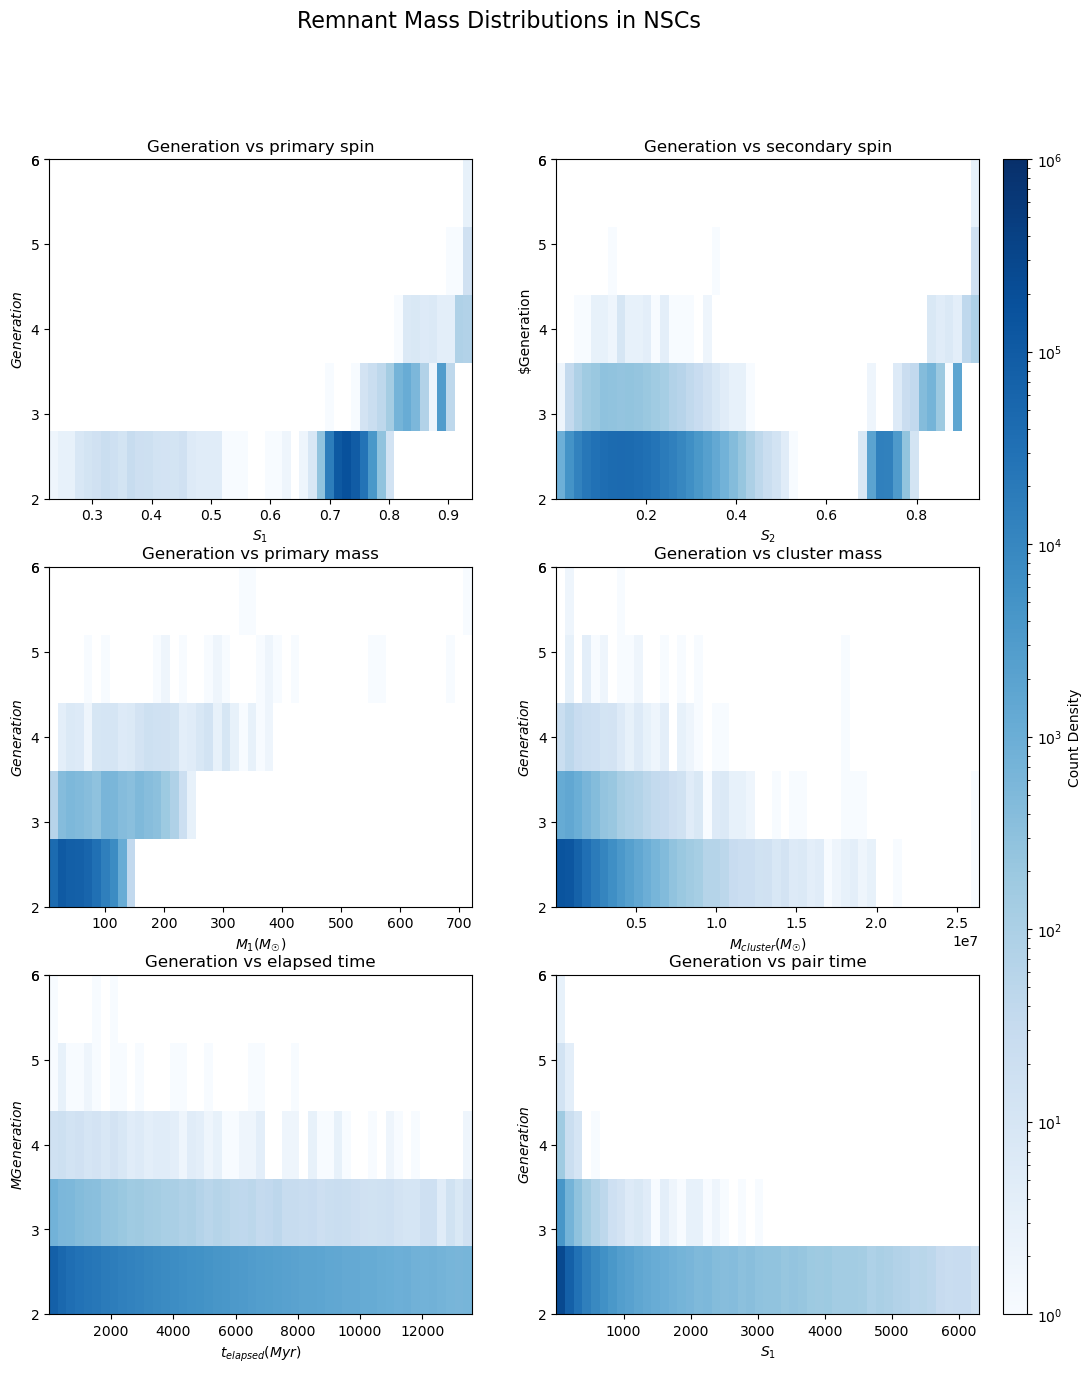

In [9]:
data = extractor('gc')
#data = data[data.Mrem<4000]
#data = data[data.M1<2000]

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in GCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.S1,data.gen,50,data.gen.max(),'Generation vs primary spin',u'$S_1$', u'$Generation$', 1, 1e6)
plt.yticks([2,3,4,5,6])

plt.sca(ax[0,1])

hist2 = hist2dgraph(data.S2,data.gen,50,data.gen.max(),'Generation vs secondary spin',u'$S_2$', u'$Generation', 1, 1e6)
plt.yticks([2,3,4,5,6])

plt.sca(ax[1,0])
hist = hist2dgraph(data.M1,data.gen,50,data.gen.max(),'Generation vs primary mass',u'$M_1 (M_\u2609)$', u'$Generation$', 1, 1e6)
plt.yticks([2,3,4,5,6])

plt.sca(ax[1,1])
jist3 = hist2dgraph(data.Mcluster,data.gen,50,data.gen.max(),'Generation vs cluster mass',u'$M_{cluster}(M_\u2609)$', u'$Generation$', 1, 1e6)
plt.yticks([2,3,4,5,6])

plt.sca(ax[2,0])
hist2 = hist2dgraph(data.t_elapsed,data.gen,50,data.gen.max(),'Generation vs elapsed time',u'$t_{elapsed}(Myr)$', u'$MGeneration$', 1, 1e6)
plt.yticks([2,3,4,5,6])
plt.sca(ax[2,1])
hist2 = hist2dgraph(data.t_pair,data.gen,50,data.gen.max(),'Generation vs pair time',u'$S_1$', u'$Generation$', 1, 1e6 )
plt.yticks([2,3,4,5,6])




cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

Cross-Validation (4-fold) Results:
R² Score: 0.9635 ± 0.0090
MAE: 0.0072 ± 0.0013
MSE: 0.0042 ± 0.0013
RMSE: 0.0642 ± 0.0097


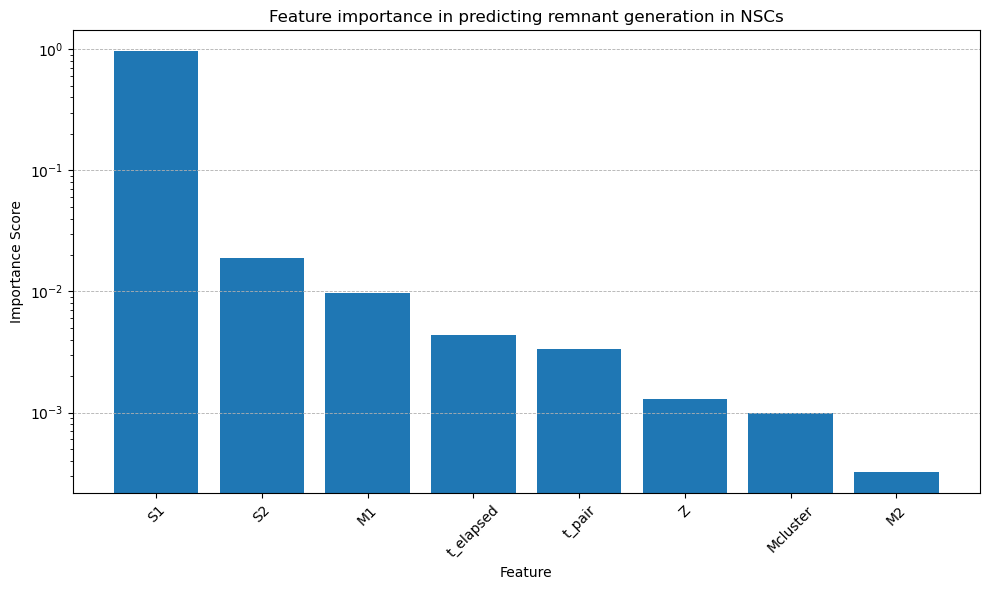

Feature importances: [9.78033325e-03 3.20240641e-04 9.60895617e-01 1.90343347e-02
 3.35047626e-03 4.32885132e-03 9.86636108e-04 1.30351088e-03]


In [10]:
rndmfrst('nsc', ['Srem','Mrem', 'kick', 'esca_v'], 'gen', 'Feature importance in predicting remnant generation in NSCs',  n_estimators=50, max_depth=10, cv=4)

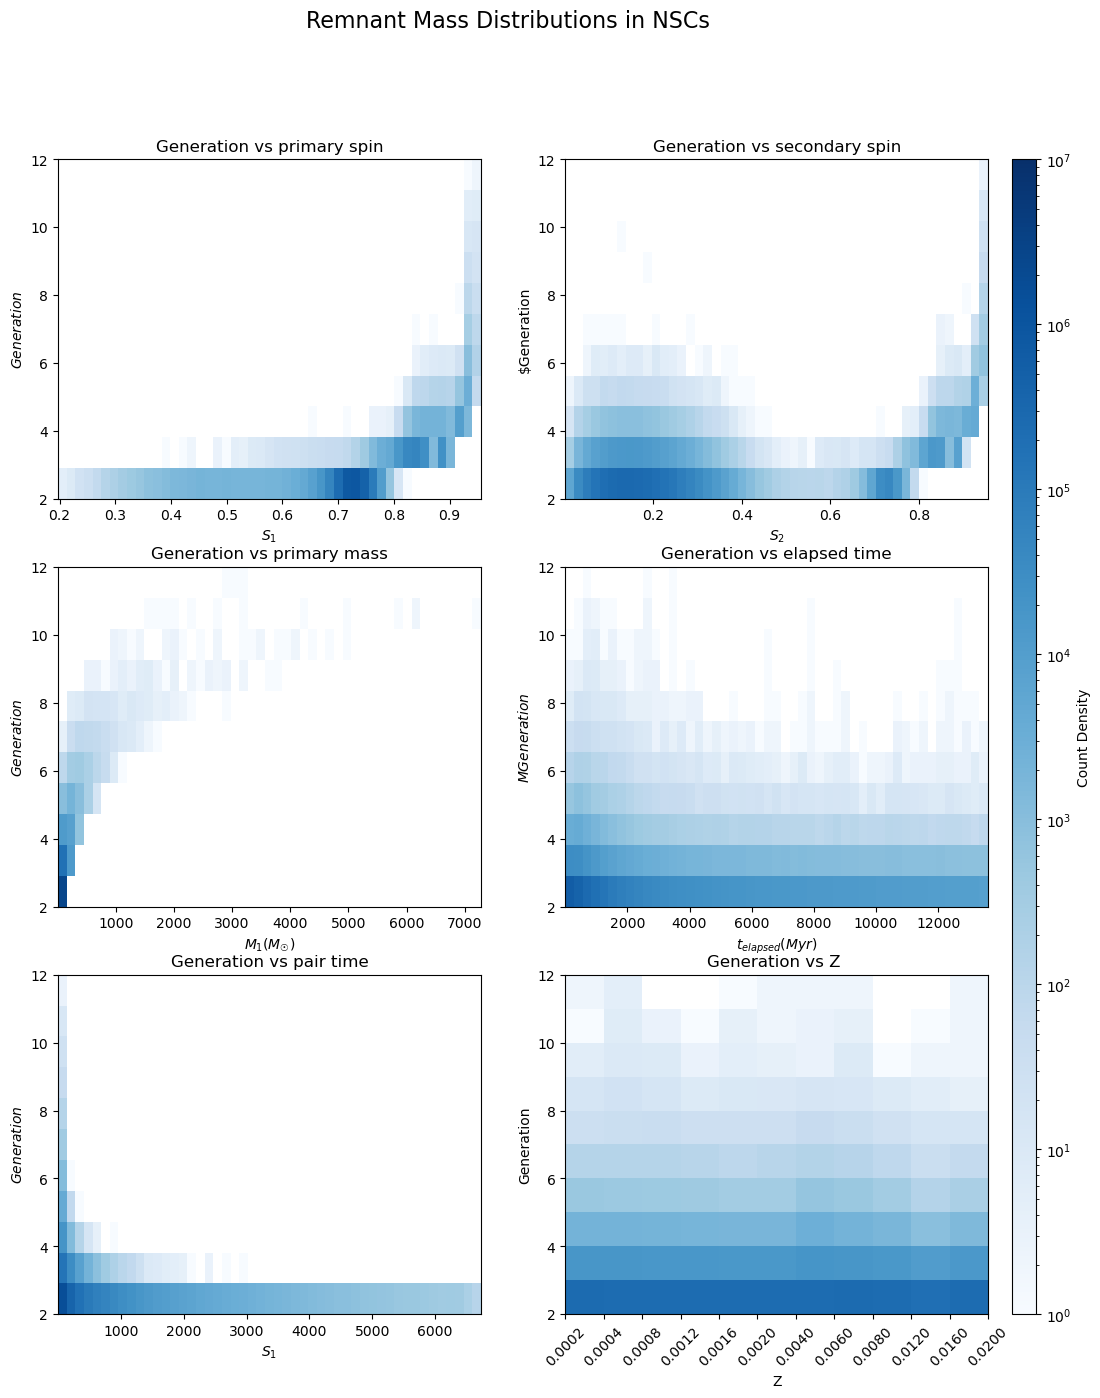

In [14]:
data = extractor('nsc')
#data = data[data.Mrem<4000]
#data = data[data.M1<2000]

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in NSCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.S1,data.gen,50,data.gen.max(),'Generation vs primary spin',u'$S_1$', u'$Generation$', 1, 1e7)


plt.sca(ax[0,1])

hist2 = hist2dgraph(data.S2,data.gen,50,data.gen.max(),'Generation vs secondary spin',u'$S_2$', u'$Generation', 1, 1e7)


plt.sca(ax[1,0])
hist = hist2dgraph(data.M1,data.gen,50,data.gen.max(),'Generation vs primary mass',u'$M_1 (M_\u2609)$', u'$Generation$', 1, 1e7)


plt.sca(ax[1,1])
hist2 = hist2dgraph(data.t_elapsed,data.gen,50,data.gen.max(),'Generation vs elapsed time',u'$t_{elapsed}(Myr)$', u'$MGeneration$', 1, 1e7)

plt.sca(ax[2,0])
hist2 = hist2dgraph(data.t_pair,data.gen,50,data.gen.max(),'Generation vs pair time',u'$S_1$', u'$Generation$', 1, 1e7 )


plt.sca(ax[2,1])

z_bins = np.array([2e-4, 4e-4, 8e-4, 12e-4, 16e-4, 2e-3, 4e-3, 6e-3, 8e-3, 12e-3, 16e-3, 2e-2])
Rem_bins = np.linspace(data.gen.min(),data.gen.max(),data.gen.max()-1) 
def forward(x):
    return np.interp(x, z_bins, np.arange(len(z_bins)))

def inverse(x):
    return np.interp(x, np.arange(len(z_bins)), z_bins)

# Create the FuncScale object correctly
scale = FuncScale(ax[2, 1].xaxis, (forward, inverse))
plt.hist2d(data.Z,data.gen, bins=(z_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e7))


# Apply the scale to the x-axis
ax[2, 1].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("linear")
plt.title('Generation vs Z ')
plt.xlabel(u'Z')
plt.ylabel(u'Generation')


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()
del data

#### PCA

In [ ]:


def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
heade = list(df.columns)
matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)            
        c = np.cov(inorm, jnorm)[0,1]
        if i=='M1' and j =='M2':
            print(c)
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


Ora , siccome alta correlazione significa che le quantità indicano più o meno la stessa grandezza e viceversa bassissima sono l'una l'inverso dell'altra, seleziono le features che hanno una correlazione compresa tra abs(0.6).
Tipo si vede che M1 e M2 hanno la stessa identica relaziono con praticamente tutte le quantità, E sono fortemente correlate con Mrem, per cui si potrebbe ridurre le features tralasciando M2 e M1 e tenendo Mrem.  S1 ha una correlazione nulla con ciascuna feature, per cui non sembra eliminabile; stessa cosa per S2. 
Per Z vediamo che corrisponde alla teoria, è inversamente proporzionale alle masse e alla massa del remnant. Il t_pair, tempo di accoppiamento è giustamente inversamente proporzionale alle masse.
T_elapsed non lo so perchè sia fortemente inv-correlato con lo spin del remnant. Escape velocity è inversamente correlato alle singole masse e direttamente alla massa totale. La generazione del buco nero è debolmente correlata a tutto, tranne che allo spin. NOn so a livello fisico cosa faccia lo spin però.

In [63]:
todo : aggiungere escape velocity

SyntaxError: invalid syntax (1812459419.py, line 1)

In [5]:
# Siccome M1,M2 sono estremamnte correlate magari prendere il rapporto tra le due potrebbe essere interessante
df= extractor(path_data, 'gc')
df = df[['M1', 'M2','Mrem', 'S1', 'S2','Srem','gen', 't_pair', 't_elapsed','kick', 'esca_v', 'Mcluster','Z'] ] # Reorder columns

In [6]:
def normer_col(df,i):
    media = df[i].mean()
    std = df[i].std()
    coso = (df[i] - media)/std
    return coso

0.8352350269111958


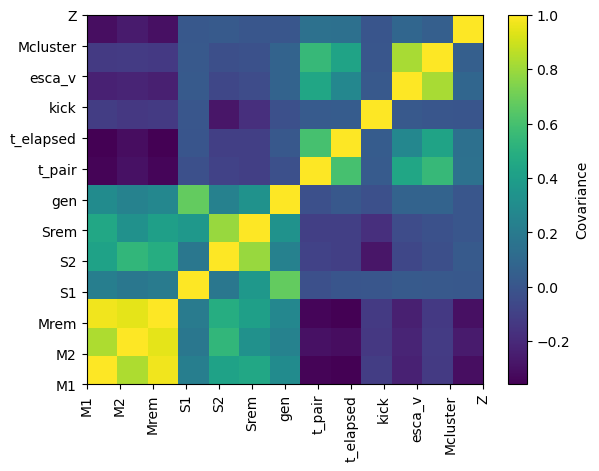

In [7]:
import matplotlib.pyplot as plt
import numpy as np
heade = list(df.columns)
matrix = np.zeros((len(heade), len(heade)))
for i in heade:
    a = heade.index(i)
    inorm = normer_col(df,i)
    for j in heade:
        #if i !=j:
        b = heade.index(j)
        jnorm = normer_col(df,j)
        #print(i,j)            
        c = np.cov(inorm, jnorm)[0,1]
        if i=='M1' and j =='M2':
            print(c)
        #print(np.cov(inorm, jnorm)[0,1])
        matrix[b,a] = c
            
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
x = x.flatten()
y = y.flatten()
values = matrix.flatten()

ticks = np.linspace(-0.5,11.5,1)
# Create a 2D histogram
plt.hist2d(x,y, weights=values, bins=(matrix.shape[1], matrix.shape[0]), cmap='viridis')
plt.colorbar(label='Covariance')
plt.xticks(ticks=np.arange(len(heade)), labels=heade, rotation=90)  # Tick for each bin, labeled with `heade`
plt.yticks(ticks=np.arange(len(heade)), labels=heade)
#plt.ylabel(heade.index())
plt.show()


#### PCA

scegliere una perentuale di varianza del dataset e la pca ti mantiene quello.